# PilotNet SDNN Example

Network excange module is available as `lava.lib.dl.netx.{hdf5, blocks, utils}`.
* `hdf5` implements automatic network generation.
* `blocks` implements individual layer blocks.
* `utils` implements hdf5 reading utilities. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io

from lava.lib.dl import netx
from dataset import PilotNetDataset

## Create network block

A network block can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as as a list: `net.layers`.

In [ ]:
# TODO: refactor sdn to sigma and delta unit
# TODO: use delta encoding at input
# TODO: use sigma decoding at output
# TODO: accumulate quantization error in residue
# TODO: enforce delta output quantization on SLAYER side
# TODO: verify sigma-delta with SLAYER calculation

In [2]:
# net = netx.hdf5.Network(net_config='network.net')
net = netx.hdf5.Network(net_config='conv_only_1chip.net')
print(net)

{'shape': (100, 33, 3), 'neuron_params': {'neuron_proc': <class 'lava.proc.sdn.process.SigmaDelta'>, 'vth': 0, 'use_graded_spikes': True}, 'transform': <function Network.create_input.<locals>.transform at 0x7f865cf03790>}
{'use_graded_spike': True}
{'use_graded_spike': True}
{'use_graded_spike': True}
{'use_graded_spike': True}
{'use_graded_spike': True}
{'use_graded_spike': True}
{'use_graded_spike': True}
{'use_graded_spike': True}
|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Input     |  100|   33|    3|     |     |     |     |     |False|
|Conv      |   49|   16|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |    1|    1|  100|20, 2| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |    1|    1|   50| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |    1|    1|  

In [3]:
for l in net.layers:
    print(l.has_graded_input)

False
True
True
True
True
True
True
True
True


In [4]:
print(f'There are {len(net)} layers in network:')

for l in net.layers:
    print(f'{l.__class__.__name__:5s} : {l.name:10s}, shape : {l.shape}, act :', l.neuron.proc_params["act_fn"])

There are 9 layers in network:
Input : Process_1 , shape : (100, 33, 3), act : ACTIVATION_MODE.Unit
Conv  : Process_3 , shape : (49, 16, 24), act : ACTIVATION_MODE.ReLU
Conv  : Process_6 , shape : (24, 7, 36), act : ACTIVATION_MODE.ReLU
Conv  : Process_9 , shape : (22, 4, 64), act : ACTIVATION_MODE.ReLU
Conv  : Process_12, shape : (20, 2, 64), act : ACTIVATION_MODE.ReLU
Conv  : Process_15, shape : (1, 1, 100), act : ACTIVATION_MODE.ReLU
Conv  : Process_18, shape : (1, 1, 50), act : ACTIVATION_MODE.ReLU
Conv  : Process_21, shape : (1, 1, 10), act : ACTIVATION_MODE.ReLU
Conv  : Process_24, shape : (1, 1, 1), act : ACTIVATION_MODE.ReLU


## Create Dataset instance
Typically the user would write it or provide it.

In [5]:
full_set = PilotNetDataset(
    path='../data',
    size=[100, 33],
    transform=net.in_layer.transform, # input transform
    visualize=True, # visualize ensures the images are returned in sequence
)
train_set = PilotNetDataset(
    path='../data',
    size=[100, 33],
    transform=net.in_layer.transform, # input transform
    train=True,
)
test_set = PilotNetDataset(
    path='../data',
    size=[100, 33],
    transform=net.in_layer.transform, # input transform
    train=False,
)

## Run the network

In [6]:
num_samples = 200
steps_per_sample = 1
num_steps = num_samples + len(net.layers)

In [7]:
run_config = Loihi1SimCfg(select_tag='fixed_pt')

In [8]:
# logger = io.sink.RingBuffer(shape=net.out_layer.shape, buffer=num_steps)
# net.out_layer.neuron.s_out.connect(logger.a_in)

In [9]:
id = 10550
gts = []
results = []
# output = []
for i in range(num_steps):
     image, gt = full_set[id + i]
     if i > 0:
          net.in_layer.neuron.bias.set(image)
          # assert np.abs(net.in_layer.neuron.bias.get() - image).sum() == 0
     else:
          net.in_layer.neuron.bias.init = image
     gts.append(gt)

     # run the network
     net.run(condition=RunSteps(num_steps=1), run_cfg=run_config)

     # gather result
     results.append(net.out_layer.neuron.sigma.get())
     print(f'\rSample: {id + i}', end='')

# output = logger.data.get()
net.stop()


Sample: 10758

In [10]:
# output.shape

In [11]:
# folder = '/home/sshresth/lava_repos/lava-netx/examples/pilotnet_sdnn/'
# out_gt = np.load(folder + f'layer{len(net) - 1}.npy')

In [12]:
# diff = output - out_gt

In [13]:
# np.argwhere(diff != 0)[:10]

In [14]:
# assert False

In [15]:
# folder = '/home/sshresth/lava_repos/lava-netx/examples/pilotnet_sdnn/'
# image, gt = full_set[10550]
# print(np.abs(image - np.load(folder + 'image.npy')).sum())

In [16]:
# # Dataloader
# interval = steps_per_sample + buffer

# # bias loader
# dataloader = io.dataloader.StateDataLoader(
#     dataset=full_set, interval=interval,
#     startId=10550 # TODO: something to tell the datloader to start from 10550
# )
# dataloader.connect_var(net.in_layer.neuron.bias)

# # spike loader
# dataloader = io.dataloader.SpikeDataLoader(
#     dataset=full_set, interval=interval,
#     startId=10550 # TODO: something to tell the datloader to start from 10550
# )
# dataloader.s_out.connect(net.in_layer.inp)

# # voltage output
# output = io.sink.Read(buffer=num_samples, interval=interval, offset=readout_offset)
# output.connect_var(net.out_layer.neuron.v)

# # spike output
# output = io.sink.RingBuffer(shape=net.out_layer.neuron.shape, buffer=num_samples)
# net.out_layer.neuron.v.connect(output.a_in)

# # reset
# for i, l in enumerate(net.layers):
#     # Execution hangs when both u and v are reset
#     u_resetter = io.reset.Reset(interval=interval, offset=i)
#     v_resetter = io.reset.Reset(interval=interval, offset=i)
#     u_resetter.connect_var(l.neuron.u)
#     v_resetter.connect_var(l.neuron.v)

# net.run(condition=RunSteps(num_samples * interval), run_cfg=run_config)
# out = output.data.get()  # [1, 1, 1, 200]
# net.stop()

# # visualization process

In [24]:
net.net_config['layer'][8]['neuron'].keys()

<KeysViewHDF5 ['activation', 'sigma_output', 'type', 'vThMant']>

## Evaluate Results

In [17]:
#TODO: remove outlier from gt in the dataset
gts[109] = (gts[108] + gts[110])/2
gts[115] = (gts[114] + gts[116])/2

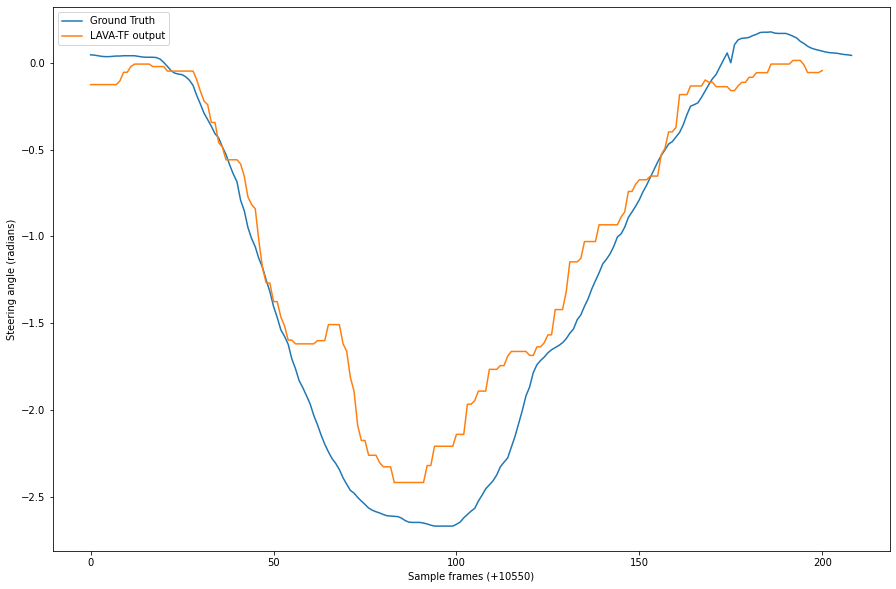

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(np.array(gts), label='Ground Truth')
plt.plot(np.array(results[len(net.layers)-1:]).flatten()/(1<<18), label='LAVA-TF output')
plt.xlabel(f'Sample frames (+{id})')
plt.ylabel('Steering angle (radians)')
plt.legend()

In [19]:
# error = np.sum((gt - results[1:])**2)
# print(f'{error=}')